In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp
import pandas as pd

%matplotlib inline

# Potential sub-surface channel
This notebook will contain the update as we step forward implementing the **Potential Sub-surface** acoustic variable.It is a boolean that indicates the potential existence of a sub-surface sound channel. 

>*A sub-surface sound channel can exist if there are two local minima in the sound speed profile above 1000 m.*

### Importing a sample profile

In [92]:
#profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T16_45_30.510267.csv", comment='/') 
profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T17_20_15.578175_POSITIVE.csv", header=2) 

In [93]:
profile.columns

Index(['Latitude', 'Longitude', 'Depth (m)', 'Pressure', 'Salinity',
       'Temperature', 'Sound Speed'],
      dtype='object')

In [94]:
profile_depth_sspeed = profile[['Sound Speed', 'Depth (m)']] # extracting only the soundspeed and depth column
profile_depth_sspeed = profile_depth_sspeed[profile_depth_sspeed ['Depth (m)'] < 1000] #taking only the rows where depth < 1000
profile_depth_sspeed


,Sound Speed,Depth (m)
0,1462.6,0.5
1,1462.6,1.5
2,1462.6,2.6
3,1462.6,3.8
4,1462.7,5.1
5,1462.7,6.4
6,1462.7,7.9
7,1462.7,9.6
8,1462.8,11.4
9,1462.8,13.5


Text(0.5, 0, 'Speed of sound [m/s]')

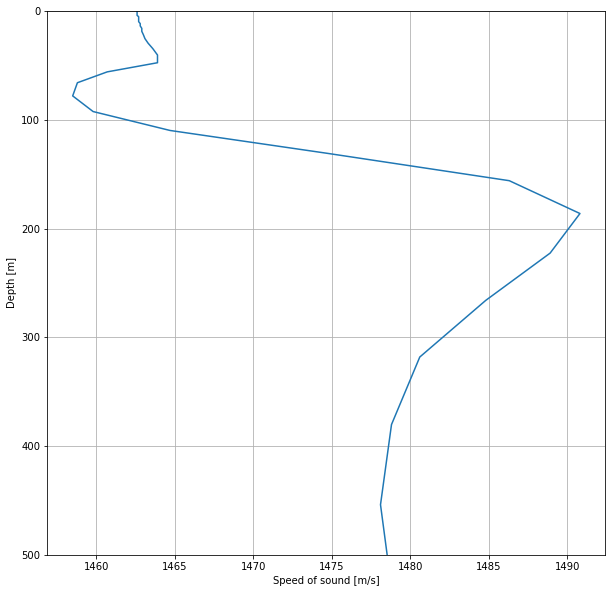

In [95]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')

Using the *argrelmin()* function from scipy to detect the localminima

In [110]:
profile_np = np.array(profile_depth_sspeed['Sound Speed'])
local_minima = sp.argrelmin(profile_np) # get the index array of local minima
local_minima =local_minima[0]
local_maxima = sp.argrelmax(profile_np) # get the index array of the local maxima
local_maxima = local_maxima[0]

Plotting the returned minima and maxima on the sound speed profile plot.

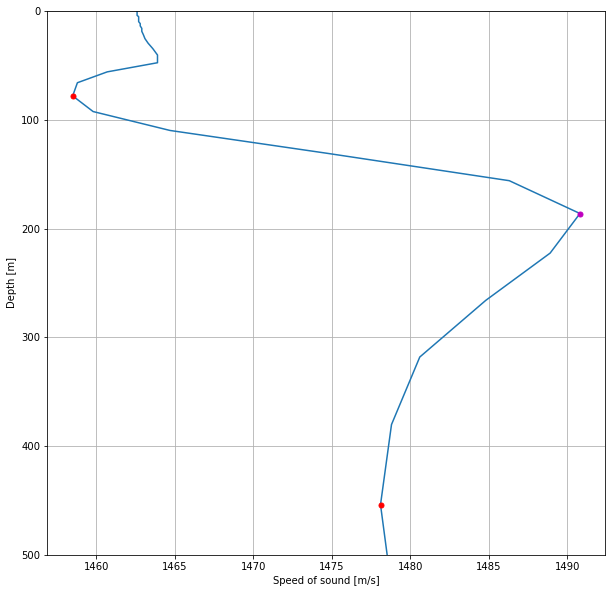

In [112]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(profile_depth_sspeed['Sound Speed'][local_minima],profile_depth_sspeed['Depth (m)'][local_minima],'r.',markersize=10)
ax.plot(profile_depth_sspeed['Sound Speed'][local_maxima],profile_depth_sspeed['Depth (m)'][local_maxima],'m.',markersize=10)

#### Checking if array *local_minima* has 2 or more minima
    - If yes, The difference in sound speed between the local maxima and the first local minimum must be greater than 5 m/s.
       
       If two local minima exist but only one local maximum exists then
   
            - The difference in the speed of sound at the surface and the first local minimum is greater than 5 m/s and the difference between the speed of sound at the local minimum and     local maximum is greater than 5 m/s.

Followed this file for reference.
https://github.com/DFO-Ocean-Navigator/Ocean-Data-Map-Project/blob/master/data/calculated_parser/functions.py

In [145]:
has_PSSC = 0
sound_speed = profile_depth_sspeed['Sound Speed']
depth = profile_depth_sspeed['Depth (m)']
if len(local_minima)>=2: #if there are 2 or more minima
    p1 = 0 # surface
    p2 = local_minima[0] #first minimum
    if len(local_maxima)>=2: # if there are more than one maxima
        p1 = local_maxima[0] #first maximum
        p3 = local_maxima[0]
    else: #only one local maximum
        p3 =  local_maxima[0] 
        if p3 < p2: # the only one maxima is higher in the water column than the minima
            has_PSSC=0
    
    p1_sound_speed = sound_speed[p1]
    p2_sound_speed = sound_speed[p2]
    p3_sound_speed = sound_speed[p3]
    
    c1 = abs(p1_sound_speed-p2_sound_speed) 
    c2 = abs(p3_sound_speed-p2_sound_speed)
    print("c1 = "+ str(c1) +"m/s")
    print("c2 = "+ str(c2) +"m/s")
    
    if c1>5 and c2>5:
        has_PSSC =1
    else:
        has_PSSC =0
else:
    has_PSSC =0 

print("Value of Potential sub-surface channel :" + str(has_PSSC))

c1 = 4.099999999999909m/s
c2 = 32.299999999999955m/s
Value of Potential sub-surface channel :0


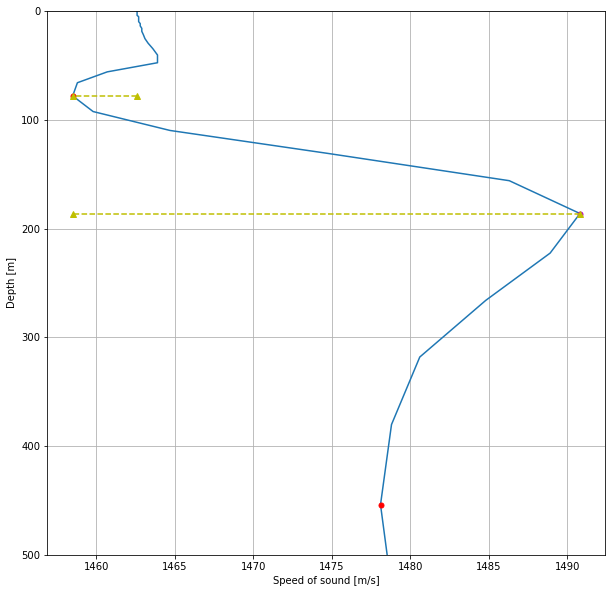

In [148]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(sound_speed,depth)
ax.grid(True)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(sound_speed[local_minima],depth[local_minima],'r.',markersize=10)
ax.plot(sound_speed[local_maxima],depth[local_maxima],'m.',markersize=10)
#plotting c1
x_p1p2 = [sound_speed[i] for i in [p1,p2]]
y_p1p2 = [depth[i] for i in [p2,p2]]
ax.plot(x_p1p2, y_p1p2, 'y^--',label= "c1")
#plotting c2
x_p3p2 = [sound_speed[i] for i in [p3,p2]]
y_p3p2 = [depth[i] for i in [p3,p3]]
ax.plot(x_p3p2, y_p3p2, 'y^--',label= "c2")